# **House Prediction Neural Network**

Intent of this notebook is to be able to predict house price from a dataset from Kaggle

##0.Import Necessary Libaries

In [ ]:
#Import necessary Libraries
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import sklearn

In [ ]:
#Check Torch Version
torch.__version__

'2.1.0+cu121'

In [ ]:
#Setup Device Agnostic Code
if torch.cuda.is_available():
  device = "cuda"
else:
  device="cpu"

device

'cpu'

##1. Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
housing_df = pd.read_csv("sample_data/Housing.csv")

len(housing_df)

545

In [ ]:
housing_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
columns_raw = housing_df.columns.tolist()
print(columns_raw)

['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [ ]:
#One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

for cols in housing_df:
  if housing_df[cols].dtype == 'int64' or housing_df[cols].dtype == 'float64':
    continue
  else:
    housing_df[cols] = housing_df[cols].astype('category')
    housing_df[f'{cols}_new'] = housing_df[cols].cat.codes

for val in columns_raw:
  if housing_df[val].dtype == 'int64' or housing_df[cols].dtype == 'float64':
    continue
  else:
    housing_df = housing_df.drop(val, axis = 1)

# Create an instance of One-hot-encoder
enc = OneHotEncoder()

# Passing encoded columns
enc_data = pd.DataFrame(enc.fit_transform(
    housing_df[['mainroad_new', 'guestroom_new','basement_new','hotwaterheating_new','airconditioning_new','prefarea_new','furnishingstatus_new']]).toarray())

# Merge with main
New_df = housing_df.join(enc_data)
print(housing_df)

        price  area  bedrooms  bathrooms  stories  parking  mainroad_new  \
0    13300000  7420         4          2        3        2             1   
1    12250000  8960         4          4        4        3             1   
2    12250000  9960         3          2        2        2             1   
3    12215000  7500         4          2        2        3             1   
4    11410000  7420         4          1        2        2             1   
..        ...   ...       ...        ...      ...      ...           ...   
540   1820000  3000         2          1        1        2             1   
541   1767150  2400         3          1        1        0             0   
542   1750000  3620         2          1        1        0             1   
543   1750000  2910         3          1        1        0             0   
544   1750000  3850         3          1        2        0             1   

     guestroom_new  basement_new  hotwaterheating_new  airconditioning_new  \
0        

price                  1.000000
area                   0.535997
bathrooms              0.517545
airconditioning_new    0.452954
stories                0.420712
parking                0.384394
Name: price, dtype: float64

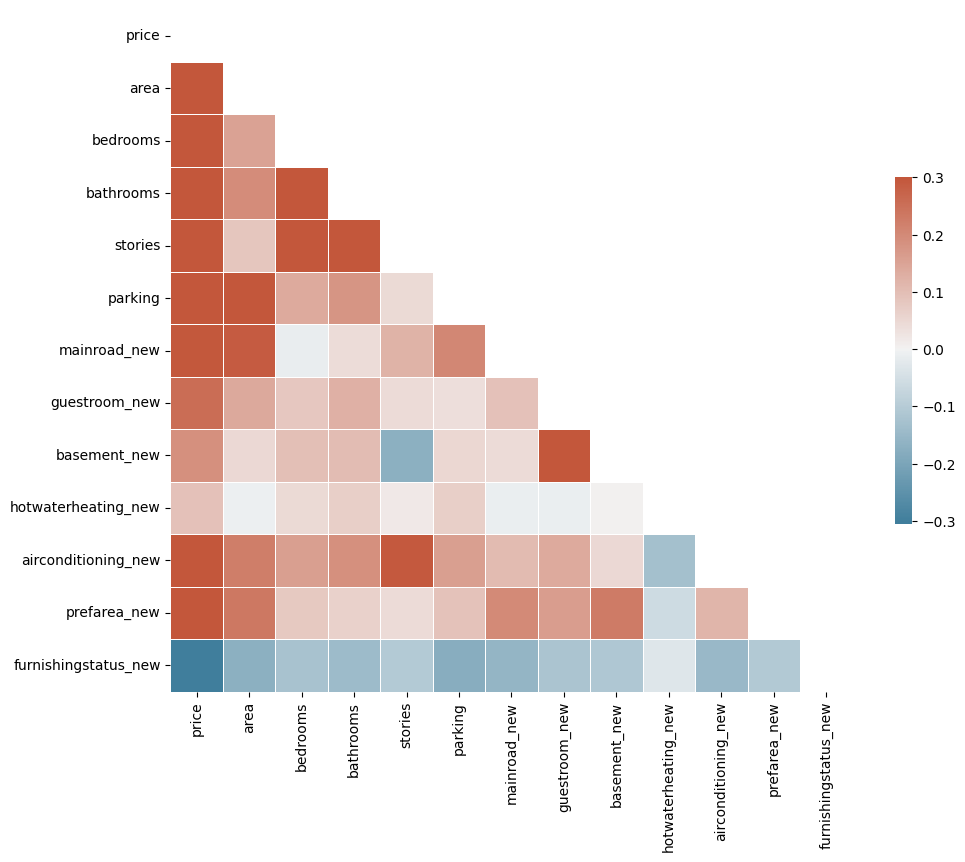

In [ ]:
import seaborn as sns
import numpy as np

rs = np.random.RandomState(42)
corr = housing_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr['price'].nlargest(6)

In [ ]:
housing_df = housing_df[['area', 'bathrooms', 'airconditioning_new', 'parking', 'stories', 'price']]

In [ ]:
housing_df.describe()

,area,bathrooms,airconditioning_new,parking,stories,price
count,545.000000,545.000000,545.000000,545.000000,545.000000,5.450000e+02
mean,5150.541284,1.286239,0.315596,0.693578,1.805505,4.766729e+06
std,2170.141023,0.502470,0.465180,0.861586,0.867492,1.870440e+06
min,1650.000000,1.000000,0.000000,0.000000,1.000000,1.750000e+06
25%,3600.000000,1.000000,0.000000,0.000000,1.000000,3.430000e+06
50%,4600.000000,1.000000,0.000000,0.000000,2.000000,4.340000e+06
75%,6360.000000,2.000000,1.000000,1.000000,2.000000,5.740000e+06
max,16200.000000,4.000000,1.000000,3.000000,4.000000,1.330000e+07


price                  1.000000
area                   0.535997
bathrooms              0.517545
airconditioning_new    0.452954
stories                0.420712
parking                0.384394
Name: price, dtype: float64

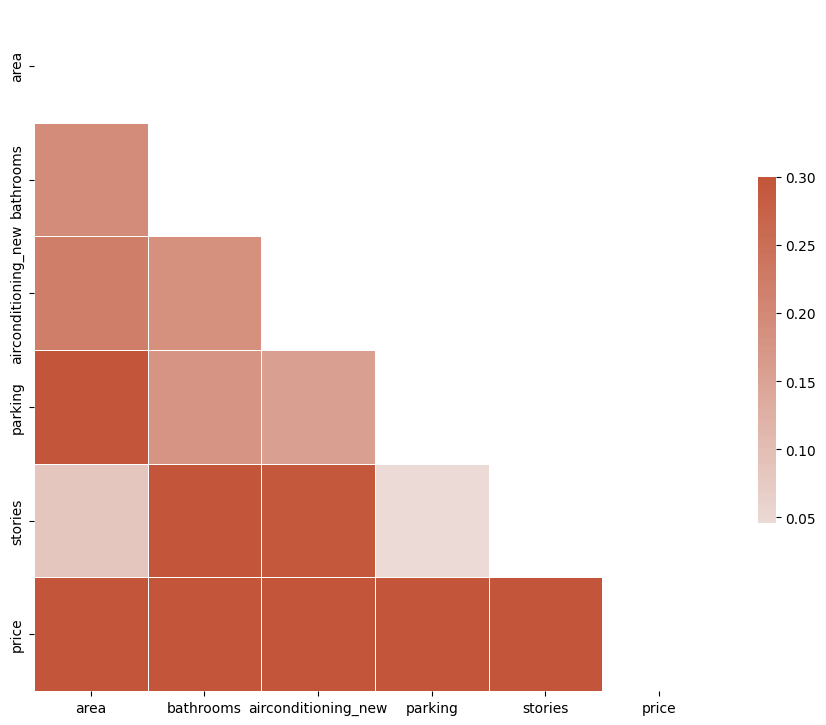

In [ ]:
rs = np.random.RandomState(42)
corr = housing_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr['price'].nlargest(6)

In [ ]:
housing_df['price'] = np.log(housing_df['price'])

In [ ]:
#Creating features and labels from input data
X = torch.tensor(housing_df.drop('price', axis=1).values, dtype=torch.float)
y = torch.tensor(housing_df['price'].values, dtype=torch.float).view(-1,1)

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #20% test, 80% train
                                                    random_state=42) #make the random split reproducible



len(X_train), len(X_test), len(y_train), len(y_test)

print(f"X size: {X.size()}, Y size: {y.size()}")


X size: torch.Size([545, 11]), Y size: torch.Size([545, 1])


##2. Build the Model

In [ ]:
#Sequential Model and ReLu Activation
housing_model_1 = nn.Sequential(
    nn.Linear(X_train.shape[1], out_features=121),
    nn.ReLU(),
    nn.Linear(in_features=121, out_features=242),
    nn.ReLU(),
    nn.Linear(in_features=242, out_features=242),
    nn.ReLU(),
    nn.Linear(in_features=242, out_features=1)
)

housing_model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1524, -0.0067, -0.2290,  ...,  0.0819,  0.0220, -0.2716],
                      [-0.0425,  0.0482,  0.1193,  ..., -0.0776, -0.2882, -0.0741],
                      [ 0.1794, -0.2584,  0.2666,  ...,  0.1718,  0.1666, -0.2857],
                      ...,
                      [-0.0307, -0.0167,  0.1788,  ...,  0.0021, -0.1134, -0.1909],
                      [ 0.0419,  0.0546,  0.1713,  ...,  0.1170, -0.1877, -0.1522],
                      [ 0.0886, -0.1612, -0.0248,  ...,  0.2988, -0.0303,  0.1551]])),
             ('0.bias',
              tensor([ 0.2422, -0.1361,  0.0912,  0.2074, -0.2620,  0.1001, -0.2236,  0.0309,
                       0.1648,  0.1066, -0.0605, -0.2120,  0.2577, -0.1061, -0.0472,  0.0732,
                       0.0873,  0.1244,  0.0844,  0.2299, -0.1650,  0.0100,  0.2319,  0.0988,
                      -0.0604,  0.2833,  0.1921, -0.0578,  0.3011,  0.2602, -0.1697, -0.0919,
                      -0.1383,  0.2966, 

##3. Train the Model

1. Forward
2. Calculate the loss
3. Zero the Gradient
4. Backward -> BackPropagation
5. Optimizer -> Gradient Descent

In [ ]:
#loss function
loss_fn_1 = torch.nn.MSELoss(reduction = 'mean')

#Optimizer
adam = torch.optim.Adam(lr = 1e-4, params = housing_model_1.parameters())

In [ ]:
#Training Loop

torch.manual_seed(42)
epochs = 10000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train_model(model):
  for epoch in range(epochs):
    #put your model in training mode
    housing_model_1.train()

    #1.Forward
    y_preds = housing_model_1(X_train)

    #2. Calculate the loss
    loss = torch.sqrt(loss_fn_1(y_preds, y_train))

    #3. Zero Gradient
    adam.zero_grad()

    #4. Backwards
    loss.backward()

    #5. Optimizer
    adam.step()

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}| Loss:{loss}")

In [ ]:
train_model(housing_model_1)
housing_model_1.state_dict()

Epoch: 0| Loss:24.57354164123535
Epoch: 100| Loss:5.787473678588867
Epoch: 200| Loss:5.756848335266113
Epoch: 300| Loss:5.723048686981201
Epoch: 400| Loss:5.685815811157227
Epoch: 500| Loss:5.644664764404297
Epoch: 600| Loss:5.598542213439941
Epoch: 700| Loss:5.545790195465088
Epoch: 800| Loss:5.483890056610107
Epoch: 900| Loss:5.416866779327393
Epoch: 1000| Loss:5.399531841278076
Epoch: 1100| Loss:5.250766277313232
Epoch: 1200| Loss:5.161895275115967
Epoch: 1300| Loss:5.21755313873291
Epoch: 1400| Loss:4.879768371582031
Epoch: 1500| Loss:4.710257530212402
Epoch: 1600| Loss:4.745462417602539
Epoch: 1700| Loss:4.4697651863098145
Epoch: 1800| Loss:4.293127059936523
Epoch: 1900| Loss:4.102028846740723
Epoch: 2000| Loss:3.8823659420013428
Epoch: 2100| Loss:3.7197680473327637
Epoch: 2200| Loss:3.457681179046631
Epoch: 2300| Loss:3.3619580268859863
Epoch: 2400| Loss:3.211116075515747
Epoch: 2500| Loss:3.0761024951934814
Epoch: 2600| Loss:2.9586966037750244
Epoch: 2700| Loss:2.861122608184814

OrderedDict([('0.weight',
              tensor([[-0.1524, -0.0067, -0.2290,  ...,  0.0819,  0.0220, -0.2716],
                      [-0.0425,  0.0482,  0.1193,  ..., -0.0776, -0.2882, -0.0741],
                      [ 0.1771,  0.0052,  0.5034,  ...,  0.2061,  0.0941, -0.2218],
                      ...,
                      [-0.0307, -0.0167,  0.1788,  ...,  0.0021, -0.1134, -0.1909],
                      [ 0.0410, -0.1524, -0.0105,  ...,  0.1155, -0.0530, -0.1578],
                      [ 0.0875, -0.2348, -0.0694,  ...,  0.4641,  0.3252,  0.3136]])),
             ('0.bias',
              tensor([ 0.2422, -0.1361,  0.6094,  0.8026, -0.8411, -0.3161, -0.2236, -0.5839,
                       0.1648,  0.1066,  0.4923,  0.1974,  0.2577, -0.7886,  0.4995, -0.4641,
                      -0.4520,  0.1244,  0.0844,  0.2299, -0.1650, -0.5715,  0.3100,  0.0988,
                      -0.0604,  0.2833,  0.5024, -0.2980,  0.3011,  0.2602,  0.4126,  0.4630,
                      -0.7490,  0.2966, 

In [ ]:
#Testing
with torch.inference_mode():
  housing_model_1.eval()

  test_preds = housing_model_1(X_test)

test_preds == y_test

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False